In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data  as pdr
import statsmodels.api as sm

from sklearn.decomposition import PCA

## Intuition
Based on the exposure analysis, the beta against U.S. government bonds is volatile:
•	Swings from high positive to deep negative.
•	Noticeable spikes in 2020 and 2022, likely reflecting interest rate volatility.

Interpretation:
•	When beta is negative, ARKK is acting as a long-duration tech asset — it drops when rates rise.
•	When it is positive, it may reflect liquidity effects or risk-off movements.
•	The high volatility in this beta indicates inconsistent correlation, suggesting pure duration hedging (TLT, IEF, SHY) may not fully capture ARKK’s sensitivity to rates, but we need to adopt hedging model that reflects rate steepening/flattening, which can be a multi-variate rolling regressiom model

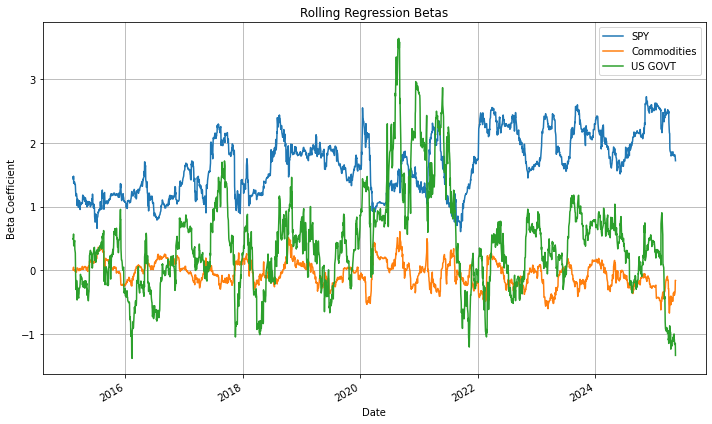

In [ ]:
start = '2014-10-31'
end = '2024-12-31'
tickers = ['ARKK', 'SPY', 'TLT', 'IEF', 'SHY']
data = pd.read_csv('data/duration_hedge_prices.csv', index_col=0, parse_dates=True).drop(columns=['^IRX'])

In [63]:
returns = data.pct_change().dropna()
window = 126
hedging_tickers = ['TLT', 'IEF', 'SHY']

In [64]:
data.head()

,ARKK,IEF,SHY,TLT
Date,,,,
2014-10-31,20.379999,105.019997,84.699997,119.250000
2014-11-03,20.379999,104.800003,84.660004,118.959999
2014-11-04,20.260000,104.790001,84.650002,119.330002
2014-11-05,20.000000,104.820000,84.629997,119.160004
2014-11-06,20.139999,104.500000,84.610001,118.389999


last Rolling Betas:
 ARKK Beta vs TLT    0.128417
ARKK Beta vs IEF    0.316033
ARKK Beta vs SHY    1.959139
Name: 2024-12-30 00:00:00, dtype: float64

last Rolling R²:
 R² vs TLT    0.002183
R² vs IEF    0.002733
R² vs SHY    0.010945
Name: 2024-12-30 00:00:00, dtype: float64

Correlation Matrix:
           ARKK       IEF       SHY       TLT
ARKK  1.000000 -0.003346  0.034842 -0.027224
IEF  -0.003346  1.000000  0.781452  0.917578
SHY   0.034842  0.781452  1.000000  0.577102
TLT  -0.027224  0.917578  0.577102  1.000000

OLS Hedge Weights:
 const    0.000698
TLT     -0.244774
IEF      0.225954
SHY      1.431581
dtype: float64


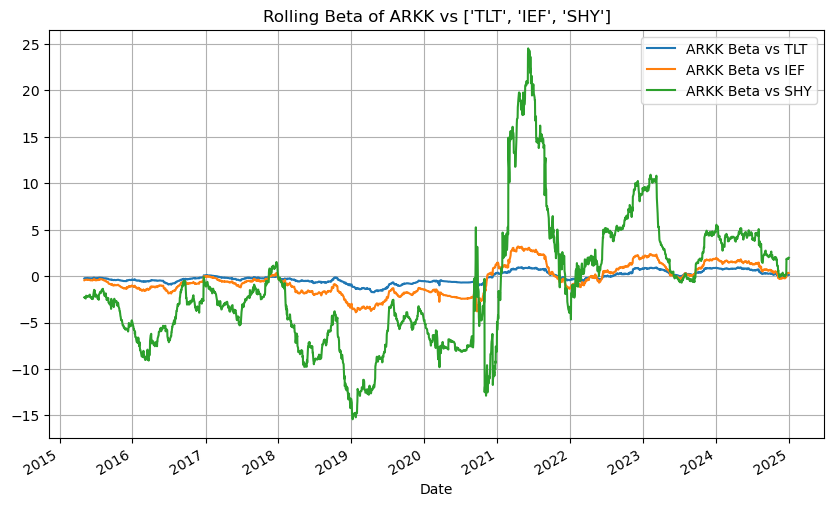

In [65]:
# Step 4: Compute rolling beta and R²
rolling_betas = pd.DataFrame(index=returns.index)
rolling_rsquared = pd.DataFrame(index=returns.index)

for hedge_asset in hedging_tickers:
    cov = returns['ARKK'].rolling(window).cov(returns[hedge_asset])
    var = returns[hedge_asset].rolling(window).var()
    rolling_betas[f'ARKK Beta vs {hedge_asset}'] = cov / var

    # Rolling R² using rolling OLS regression
    def rolling_r2(x):
        x = x.reshape(-1, 2)
        y = x[:, 0]
        X = sm.add_constant(x[:, 1])
        model = sm.OLS(y, X).fit()
        return model.rsquared

    combined = returns[['ARKK', hedge_asset]].dropna().to_numpy()
    rolling_rsq = pd.Series(
        [rolling_r2(combined[i - window:i]) for i in range(window, len(combined) + 1)],
        index=returns.index[window - 1:]
    )
    rolling_rsquared[f'R² vs {hedge_asset}'] = rolling_rsq

# Step 5: Correlation matrix
correlation_matrix = returns.corr()

# Step 6: Static hedge via OLS
Y = returns['ARKK']
X = sm.add_constant(returns[hedging_tickers])
model = sm.OLS(Y, X).fit()
hedge_weights = model.params

# Print results
print("last Rolling Betas:\n", rolling_betas.iloc[-1])
print("\nlast Rolling R²:\n", rolling_rsquared .iloc[-1])
print("\nCorrelation Matrix:\n", correlation_matrix)
print("\nOLS Hedge Weights:\n", hedge_weights)

# Optional: Plot
rolling_betas.plot(title=f'Rolling Beta of ARKK vs {hedging_tickers}', figsize=(10, 6))
plt.grid(True)
plt.show()

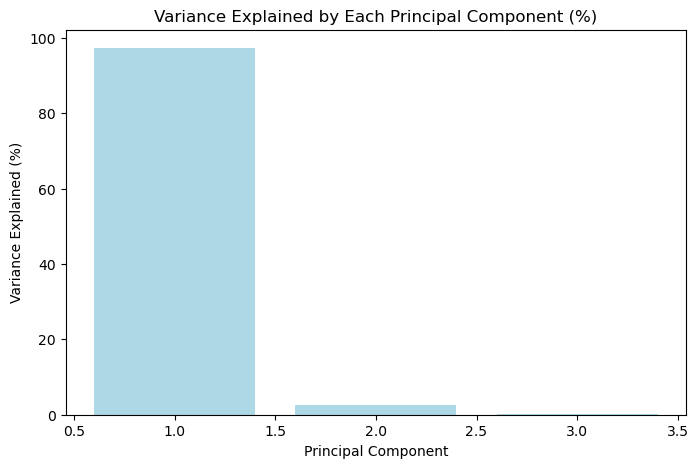


Explained Variance Ratios:
[0.97258825 0.02535566 0.00205609]

Principal Components (Factor Loadings):
          TLT       IEF       SHY
PC1  0.921632  0.383451  0.059659
PC2 -0.375246  0.841408  0.388874
PC3  0.098917 -0.380785  0.919357

Correlation with ARKK:
PC1   -0.023497
PC2    0.059426
PC3    0.024332
dtype: float64


In [66]:

pca_n_components = 3

rate_returns = returns[hedging_tickers]
pca = PCA(n_components=pca_n_components)
pca.fit(rate_returns)

explained_variance = pca.explained_variance_ratio_
components = pd.DataFrame(pca.components_, columns=[hedging_tickers], index=[f'PC{i+1}' for i in range(pca_n_components)])

# Step 5: Project ARKK returns onto PCA components
transformed = pca.transform(rate_returns)
pca_returns = pd.DataFrame(transformed, columns=[f'PC{i+1}' for i in range(pca_n_components)], index=rate_returns.index)

correlations = pca_returns.corrwith(returns['ARKK'])

plt.figure(figsize=(8, 5))
plt.bar(range(1, 4), explained_variance * 100, color='lightblue')
plt.title("Variance Explained by Each Principal Component (%)")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.show()

# Output analysis
print("\nExplained Variance Ratios:")
print(explained_variance)

print("\nPrincipal Components (Factor Loadings):")
print(components)

print("\nCorrelation with ARKK:")
print(correlations)

# Rolling Regression Hedge Using ETF

Hit the cap on 1.9% of days
             Unhedged  Gross Hedge  Net Hedge
Final Value  2.815738     3.618297   2.952309
Volatility   0.392454     0.390056   0.390146
Sharpe       0.485198     0.556235   0.499299


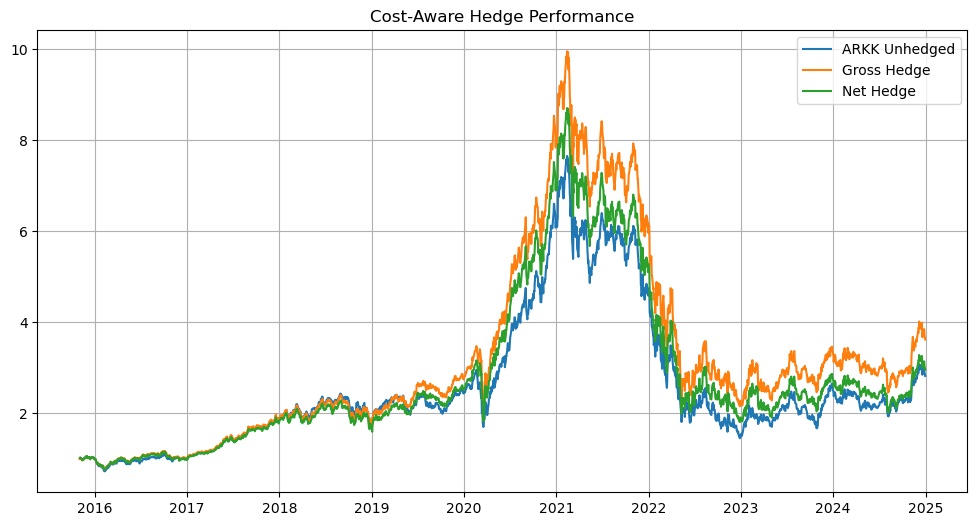

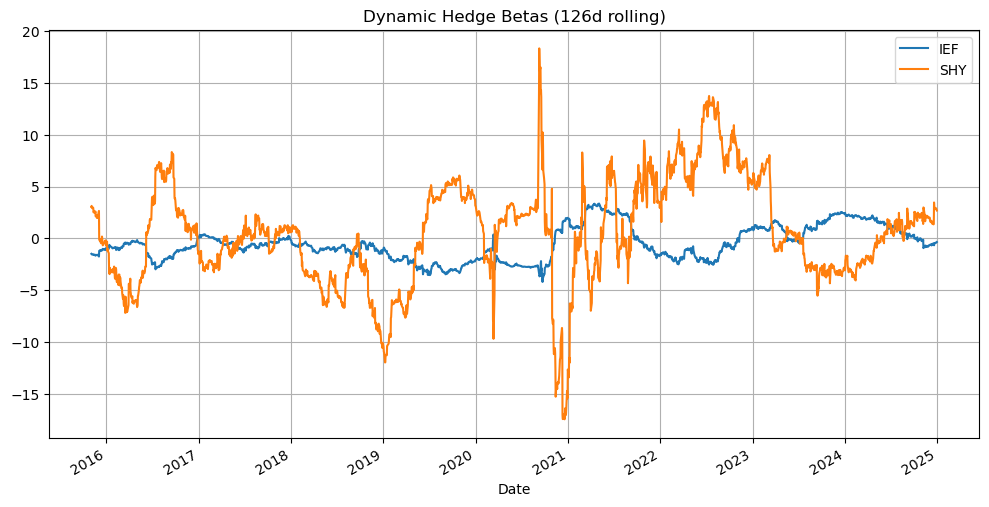

In [322]:
window = 126
hedging_tickers = ['IEF', 'SHY']
betas_dynamic = pd.DataFrame(index=returns.index, columns=['const'] + hedging_tickers)

for i in range(window, len(returns)):
    y = returns['ARKK'].iloc[i-window:i]
    # X = sm.add_constant(returns[['TLT','IEF','SHY']].iloc[i-window:i])
    X = sm.add_constant(returns[hedging_tickers].iloc[i-window:i])
    mdl = sm.OLS(y, X).fit()
    betas_dynamic.iloc[i] = mdl.params

betas_dynamic = betas_dynamic.dropna()
mask = betas_dynamic.index

returns = returns.loc[mask]

gross_hedged = returns.loc[mask, 'ARKK'] - (
    # betas_dynamic['TLT'] * returns['TLT'].loc[betas_dynamic.index] +
    betas_dynamic['IEF'] * returns['IEF'] +
    betas_dynamic['SHY'] * returns['SHY']
)

hedge_pct_cap = 10

gross_pct = betas_dynamic.sum(axis=1)
scale = np.where(gross_pct.abs() > hedge_pct_cap, hedge_pct_cap / gross_pct, 1.0)

cap_hits = (gross_pct > hedge_pct_cap).mean()
print(f"Hit the cap on {cap_hits:.1%} of days")

gross_hedged = returns['ARKK'] - (
    betas_dynamic['IEF'] * scale * returns['IEF'] +
    betas_dynamic['SHY'] * scale * returns['SHY']
)

# 5. Position sizing and cost assumptions
N = 9_000_000_000  # $9B notional
trade_cost_pct = {'TLT': 0.0001, 'IEF': 0.0001, 'SHY': 0.0001}
borrow_rate = {'TLT': 0.004, 'IEF': 0.004, 'SHY': 0.004}

prices = data[hedging_tickers].loc[betas_dynamic.index]

# 6. Daily positions (shares)
positions = betas_dynamic[hedging_tickers].multiply(N).divide(prices)

# 7. Turnover and trade cost
shares_diff = positions.diff().abs()
turnover_value = shares_diff.multiply(prices)
daily_trade_cost = sum(turnover_value[col] * trade_cost_pct[col] for col in turnover_value.columns)

# 8. Borrow cost for shorts
short_shares = positions.clip(upper=0).abs()
borrow_cost = sum(short_shares[col] * prices[col] * (borrow_rate[col]/252) for col in short_shares.columns)

# 9. Net hedged returns
daily_cost = (daily_trade_cost + borrow_cost) / N
net_hedged = gross_hedged - daily_cost

# 10. Performance stats
def perf_stats(r):
    return pd.Series({
        'Final Value': (1+r).cumprod().iloc[-1],
        'Volatility': r.std()*np.sqrt(252),
        'Sharpe': r.mean()/r.std()*np.sqrt(252)
    })

idx = gross_hedged.index
stats = pd.DataFrame({
    'Unhedged': perf_stats(returns['ARKK'].loc[idx]),
    'Gross Hedge': perf_stats(gross_hedged),
    'Net Hedge': perf_stats(net_hedged)
})

print(stats)

# 11. Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot((1+returns['ARKK'].loc[idx]).cumprod(), label='ARKK Unhedged')
plt.plot((1+gross_hedged).cumprod(), label='Gross Hedge')
plt.plot((1+net_hedged).cumprod(), label='Net Hedge')
plt.legend(); plt.title('Cost‐Aware Hedge Performance'); plt.grid(True)
plt.show()

# 12. Plot rolling betas
betas_dynamic[hedging_tickers].plot(figsize=(12,6))
plt.title('Dynamic Hedge Betas (126d rolling)'); plt.grid(True)
plt.show()

Compute Hedge Notional

6.217031551858232


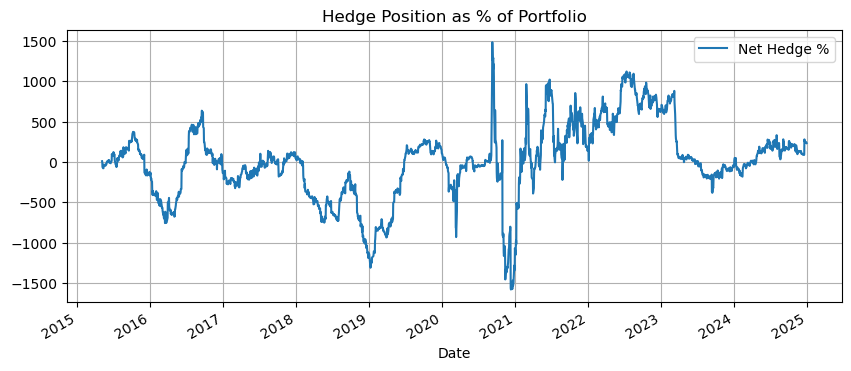

In [242]:

V = (1 + returns['ARKK']).cumprod()
net_hedge_pct = betas_dynamic[hedging_tickers].sum(axis=1) * 100

# 5) Inspect or plot:
print(net_hedge_pct.mean())

# 6) Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
net_hedge_pct.plot(label='Net Hedge %')
plt.legend(); plt.title("Hedge Position as % of Portfolio"); plt.grid(True)

## comments: This doesn't make sense, the hedge notional routinely spikes to 10× of equity book. We should shift the hedging universe to derivatives, like rates/bond futures:
	1.	Replace the IEF/SHY legs in your hedge with the corresponding T-Note (TY, FV) or Eurodollar/SOFR futures.
	2.	Recompute rolling betas \beta_{TY},\beta_{FV} using futures returns instead of ETF returns.
	3.	Size your futures position by
\text{Contracts}_t
= \frac{\beta_t \times V_t}{\text{Futures\ Notional}}
rather than buying \beta_t \times V_t dollars of ETF.

Rolling Regression Beta Hedge Using Treasury Note Futures

# Rolling Regression Beta Hedge Using Treasury Note Futures

In [125]:

# fact sheet
# https://www.cmegroup.com/trading/interest-rates/basics-of-us-treasury-futures.html

window = 63
market_beta_symbols = ["SPY"]
hedging_symbols = ['ZT=F', 'ZF=F', 'ZN=F']

# Path to your CSV:
csv_path = 'data/rates_hedge_prices.csv'
N = 9_000_000_000       # $9 B portfolio
cm = 1000               # $1 000 per futures point

# the spread cost per contract as dollar value of min tick size
spread_cost_per_contract = {
    "ZT=F": 7.8125,
    "ZF=F": 7.8125,
    "ZN=F": 15.625,
}

# dollar per contract
initial_margin = {
    "ZT=F": 1200,
    "ZF=F": 1250,
    "ZF=F": 1875,
}

# 2% annual funding
fin_rate = 0.02

In [126]:
spread_cost_per_contract_series = pd.Series(data=spread_cost_per_contract)
initial_margin_series = pd.Series(data=initial_margin)

In [127]:
returns = data.pct_change().dropna()

/var/folders/y2/0_482wmd2w79jngp561b2h580000gn/T/ipykernel_23665/1517689983.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


In [128]:
data = pd.read_csv(csv_path, index_col=0, parse_dates=True).sort_index()

# generate P&L series
pnl = pd.DataFrame(index=data.index)
pnl['ARKK'] = data['ARKK'].pct_change() * N
pnl[market_beta_symbols] = data[market_beta_symbols].pct_change()
pnl[hedging_symbols] = data[hedging_symbols].diff()  * cm
pnl.dropna(inplace=True)

# use rolling OLS to estimate contract betas per $1
betas = pd.DataFrame(index=pnl.index, columns=hedging_symbols)
for i in range(window, len(pnl)):
    y = pnl['ARKK'].iloc[i-window:i]
    X = sm.add_constant(pnl[market_beta_symbols + hedging_symbols].iloc[i-window:i])
    model = sm.OLS(y, X).fit()
    betas.iloc[i] = model.params[hedging_symbols]
betas.dropna(inplace=True)

# quarterly rebalancing schedule
rebal_dates = betas.groupby(pd.Grouper(freq='Q')).apply(lambda df: df.index[-1]).values

# build rebalanced positions based on rebalance schedule
positions = -betas  # contracts per N notional
positions_q = positions.loc[rebal_dates]
positions_ffill = positions_q.reindex(positions.index).ffill()

# calculate hedge return
hedged_pnl = pnl['ARKK'] + (positions_ffill * pnl[hedging_symbols]).sum(axis=1)
hedged_returns = hedged_pnl / N
arkk_returns = pnl['ARKK'] / N

# calculate cost
# transaction cost on rebal
turnover = positions_ffill.diff().abs().fillna(0)
turnover.loc[~turnover.index.isin(rebal_dates)] = 0
transaction_cost = (turnover * spread_cost_per_contract_series).sum(axis=1) / N

# margin financing cost
daily_margin_cost = (positions_ffill.abs() * initial_margin_series * (fin_rate/252)).sum(axis=1) / N

# Net hedged returns
net_returns = hedged_returns - transaction_cost - daily_margin_cost

/var/folders/y2/0_482wmd2w79jngp561b2h580000gn/T/ipykernel_23665/1162502206.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pnl['ARKK'] = data['ARKK'].pct_change() * N
/var/folders/y2/0_482wmd2w79jngp561b2h580000gn/T/ipykernel_23665/1162502206.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pnl[market_beta_symbols] = data[market_beta_symbols].pct_change()
/var/folders/y2/0_482wmd2w79jngp561b2h580000gn/T/ipykernel_23665/1162502206.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  rebal_dates = betas.groupby(pd.Grouper(freq='Q'))

              Unhedged  Gross Hedge  Net Hedge
Final Value   3.321267     4.361264   3.849956
Volatility    0.387193     0.389630   0.393570
Sharpe Ratio  0.493610     0.560654   0.536526


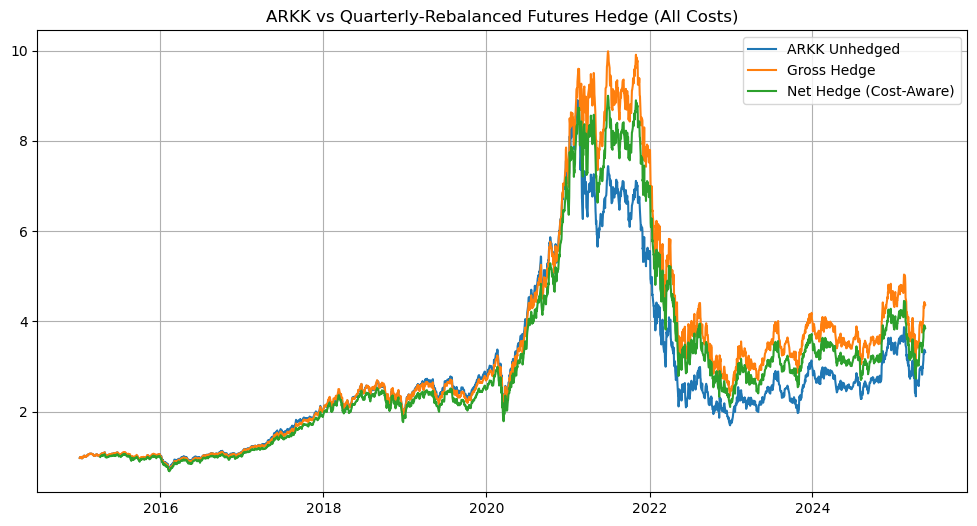

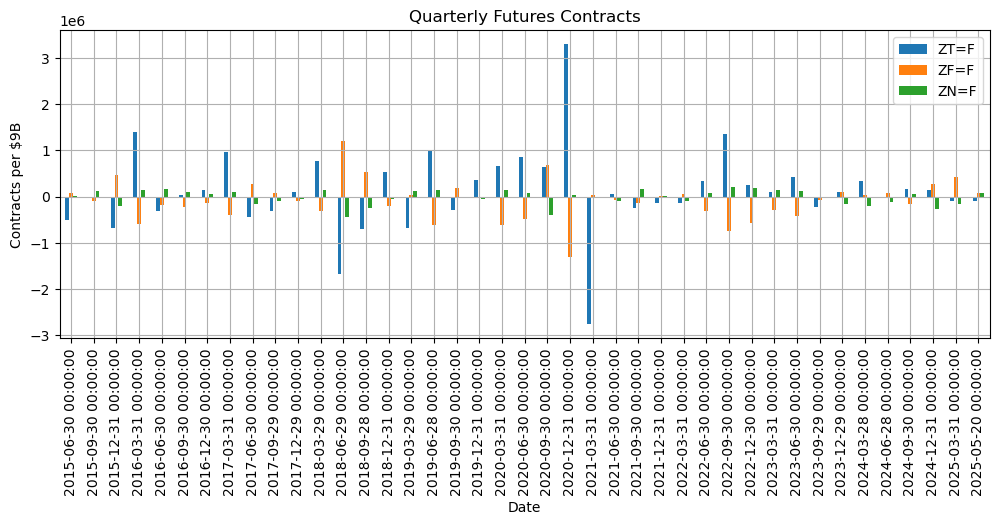

In [129]:
def perf_stats(r):
    return pd.Series({
        'Final Value': (1 + r).cumprod().iloc[-1],
        'Volatility': r.std() * np.sqrt(252),
        'Sharpe Ratio': r.mean() / r.std() * np.sqrt(252)
    })

idx = net_returns.index
metrics = pd.DataFrame({
    'Unhedged': perf_stats(arkk_returns.loc[idx]),
    'Gross Hedge': perf_stats(hedged_returns.loc[idx]),
    'Net Hedge': perf_stats(net_returns.loc[idx])
})
print(metrics)

plt.figure(figsize=(12,6))
plt.plot((1+arkk_returns.loc[idx]).cumprod(), label='ARKK Unhedged')
plt.plot((1+hedged_returns.loc[idx]).cumprod(), label='Gross Hedge')
plt.plot((1+net_returns.loc[idx]).cumprod(), label='Net Hedge (Cost-Aware)')
plt.title('ARKK vs Quarterly-Rebalanced Futures Hedge (All Costs)')
plt.legend(); plt.grid(True)
plt.show()

positions_ffill.loc[rebal_dates].plot(kind='bar', figsize=(12,4))
plt.title('Quarterly Futures Contracts')
plt.ylabel('Contracts per $9B')
plt.grid(True)
plt.show()

Latest Margin Usage:
  Dollars: 270,588,805
  % of AUM: 3.01%


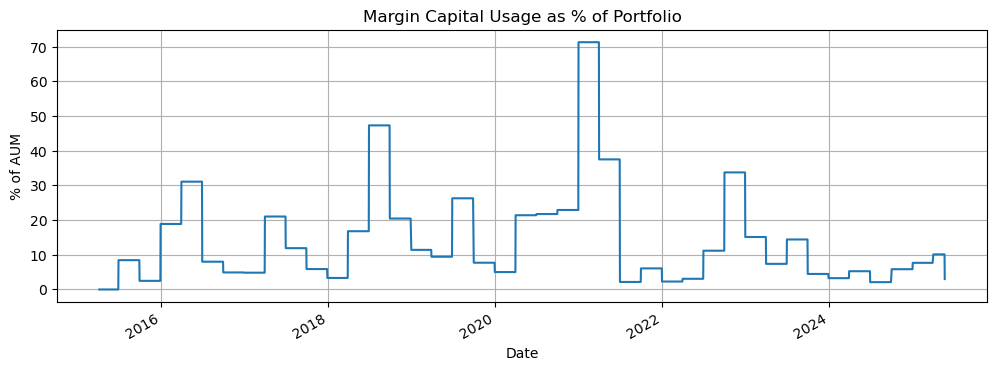

In [130]:
# 1. Margin requirement per day ($)
margin_requirement = positions_ffill.abs().multiply(initial_margin_series, axis=1)

# 2. Total margin used ($)
total_margin_used = margin_requirement.sum(axis=1)

# 3. Margin as % of portfolio AUM
margin_pct = total_margin_used / N * 100

# 4. Review results
print("Latest Margin Usage:")
print(f"  Dollars: {total_margin_used.iloc[-1]:,.0f}")
print(f"  % of AUM: {margin_pct.iloc[-1]:.2f}%")

# Optional: plot over time
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
margin_pct.plot()
plt.title('Margin Capital Usage as % of Portfolio')
plt.ylabel('% of AUM')
plt.grid(True)
plt.show()

In [118]:
margin_pct.mean()

11.076451999504084